In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ltspice
import subprocess
import pickle

creating the top, finite elements and bottom grid

In [2]:
def netlist_solar_cell_fin_ele(Rsh, Rsr, I, indx, indy):
    netlist =f"""
I{indx}{indy} T{indx}{indy} N{indx}{indy} {I}
D{indx}{indy} N{indx}{indy} T{indx}{indy} D
Rshunt{indx}{indy} N{indx}{indy} T{indx}{indy} {Rsh}
Rseries{indx}{indy} B{indx+1}{indy+1} N{indx}{indy} {Rsr}
"""
    return netlist

def netlist_solar_cell_top_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    for j in range(0, m+1):  # Loop through rows of fingers
        for i in range(0, n):  # Loop through columns of fingers
            line = f"RF_f{i}{j} T{i}{j} T{i+1}{j} {R_fingers[j][i]}\n"
            netlist += line  # Add to the netlist
    
    # Rows - Busbars
    for i in range(0, n+1):  # Loop through columns of busbars
        for j in range(0, m):  # Loop through rows of busbars
            line = f"RF_b{i}{j} T{i}{j} T{i}{j+1} {R_bb[i][j]}\n"
            netlist += line  # Add to the netlist
            
    return netlist

def netlist_solar_cell_bottom_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    for j in range(0, m):  # Loop through rows of fingers
        for i in range(0, n):  # Loop through columns of fingers
            line = f"RB_f{i}{j} B{i}{j} B{i+1}{j} {R_fingers[j][i]}\n"
            netlist += line  # Add to the netlist
    
    # Rows - Busbars
    for i in range(0, n):  # Loop through columns of busbars
        for j in range(0, m):  # Loop through rows of busbars
            line = f"RB_b{i}{j} B{i}{j} B{i}{j+1} {R_bb[i][j]}\n"
            netlist += line  # Add to the netlist
    
    return netlist

def netlist_V_source():
    netlist = f"V1 B00 T33 DC 0\n"
    return netlist

def netlist_simtype():
    netlist = ".dc V1 0 1 0.01\n"
    return netlist


In [3]:
#number of finite element n x m (row x coloum) 

n = 3
m = 3

Rsh = [[1000, 1100, 900], [1000, 1100, 900], [1000, 1100, 900]] #R series
Rsr = [[0.001, 0.0009, 0.0011], [0.001, 0.0009, 0.0011], [0.001, 0.0009, 0.0011]] #R shunt
I = 2

file_path = 'spice_models\\finit_elements\\'

top_grid_R_fing = [[0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001]]
top_grid_R_bb = [[0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001]]

bottom_grid_R_fing = [[0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001]]
bottom_grid_R_bb = [[0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001], [0.0001, 0.0001, 0.0001]]

In [4]:
def solar_cell_netlist():

    # Initialize the netlist with the header
    netlist = """* C:\\Drive\\semester 7\\BTP-1\\work4_EL\\finite_element_model\\spice_models\\solar_cell.asc\n"""
    
    # top resistance grid
    # nodes from T00 to Tnn
    netlist += netlist_solar_cell_top_ele(top_grid_R_fing, top_grid_R_bb, n, m)

    # finite element
    for i in range(0,n):
        for j in range(0,m):    
            netlist += netlist_solar_cell_fin_ele(Rsh[i][j], Rsr[i][j], I, i, j)
    
    # bottom resistance grid
    # nodes from B00 to Bnn
    netlist += netlist_solar_cell_bottom_ele(bottom_grid_R_fing, bottom_grid_R_bb, n, m)

    # adding the voltage source
    netlist += netlist_V_source()

    # adding the simulation type
    netlist += netlist_simtype()

    # replacing the node T22 with ground
    netlist = netlist.replace(" T33", " 0")

    # Add the footer
    netlist += """.model D D
.lib C:\\Users\\manik\\AppData\\Local\\LTspice\\lib\\cmp\\standard.dio
.backanno
.end"""

    return netlist


output_file = file_path + f"solar_cell.net"
with open(output_file, 'w') as file:
    file.write(solar_cell_netlist())

now i have the netlist ready lets try simulating it!

In [5]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Users\\manik\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

# Path to the netlist file
netlist_file = "spice_models\\finit_elements\\solar_cell.net"

#running simulation
RunLTsimulation(netlist_file)

In [6]:
# Extract data
# Load the LTSpice data
lt = ltspice.Ltspice("spice_models\\finit_elements\\solar_cell.raw")
lt.parse()

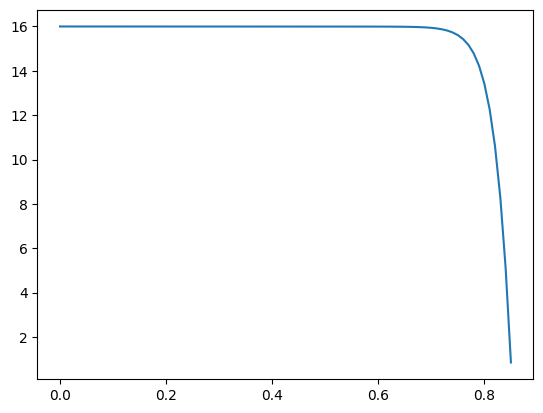

In [7]:
I = lt.get_data("I(V1)")
V = lt.get_data("v1")
#find the point where I becomes zero and stop ploting there
zero_crossing_index = np.argmax(I <= 0)  # First index where I <= 0

# Slice the data up to the zero-crossing point
V_trimmed = V[:zero_crossing_index]
I_trimmed = I[:zero_crossing_index]

plt.plot(V_trimmed,I_trimmed )
